In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
gazebo_static = pd.read_csv("data/Gazebo/static_test.csv")
gazebo_static_fps = pd.read_csv("data/Gazebo/static_gazebo_fps.csv")
gazebo_dynamic = pd.read_csv("data/Gazebo/dynamic_test.csv")
gazebo_dynamic_fps = pd.read_csv("data/Gazebo/dynamic_gazebo_fps.csv")

# Drop first entry for every experiment (incorrect RTF)
gazebo_static = gazebo_static.groupby("count").apply(lambda group: group.iloc[1:]).reset_index(drop=True)
gazebo_dynamic = gazebo_dynamic.groupby("count").apply(lambda group: group.iloc[1:]).reset_index(drop=True)

# Convert CPU readings to lists of floats
gazebo_static["CPU"] = gazebo_static["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
gazebo_dynamic["CPU"] = gazebo_dynamic["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))

gazebo_static["CPU_ALL"] = gazebo_static["CPU"].apply(lambda x: np.mean(x))
gazebo_dynamic["CPU_ALL"] = gazebo_dynamic["CPU"].apply(lambda x: np.mean(x))

gazebo_static_tmp = gazebo_static.groupby(["test", "count"]).agg("mean").reset_index()
gazebo_static_tmp["FPS"] = gazebo_static_fps["FPS"]
gazebo_static_tmp["CPU"] = gazebo_static[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
gazebo_static = gazebo_static_tmp

gazebo_dynamic_tmp = gazebo_dynamic.groupby(["test", "count"]).agg("mean").reset_index()
gazebo_dynamic_tmp["FPS"] = gazebo_dynamic_fps["FPS"]
gazebo_dynamic_tmp["CPU"] = gazebo_dynamic[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
gazebo_dynamic = gazebo_dynamic_tmp

In [128]:
gazebo_tests = pd.concat([gazebo_static, gazebo_dynamic])
gazebo_tests["RAM_USED"] = gazebo_tests["RAM_USED"] / (1024**3)  # Bytes to GiB (Gibibytes)
gazebo_tests["FPS_SCALED"] = gazebo_tests["FPS"]*gazebo_tests["RTF"]

gazebo_static = gazebo_tests[gazebo_tests["test"] == "static"]
gazebo_dynamic = gazebo_tests[gazebo_tests["test"] == "dynamic"]

<AxesSubplot:xlabel='count'>

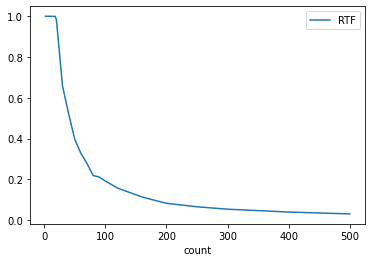

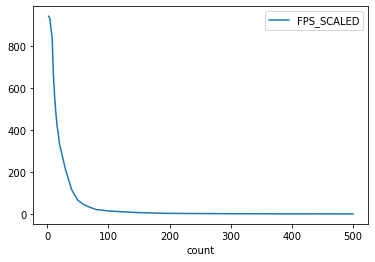

In [132]:
gazebo_dynamic.plot(x="count", y="RTF")
gazebo_dynamic.plot(x="count", y="FPS_SCALED")

In [ ]:
gazebo_tests[]